# Offline hand-eye callibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from apriltag import apriltag

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration, frame_is_valid, compute_TCP_image_position, compute_target_to_gripper_transform, compute_target_image_position, compute_reprojection_error_mean_max

In [2]:
data_root = '../doc/sample_data/calibration/calibdata_2025_08_11-11_51_22'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

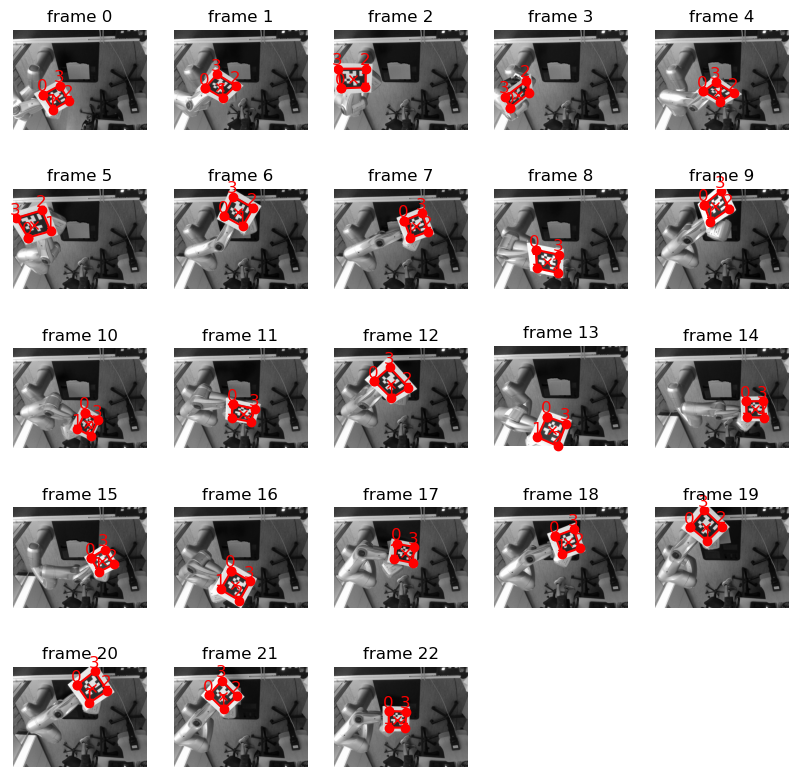

In [3]:
apriltag_family = 'tag36h11'
detector = apriltag(apriltag_family)

num_frames = len(glob.glob1(data_root, "frame_*.pkl"))
plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, num_frames-1, min(num_frames, 25), dtype=int)): 
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(10, data_root, detector)
frame

{'image_timestamp': (1754913281, 881792236),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', 0.5927182330326759),
                            ('y', 0.9605102301348581),
                            ('z', 0.017515726128091158)])),
              ('rotation',
               OrderedDict([('x', 0.848245601608102),
                            ('y', 0.21850021141091713),
                            ('z', -0.4217332821607434),
                            ('w', 0.23426074294217644)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754913281),
                                          ('nanosec', 481502441)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
          

In [5]:
frame_samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)
    if not frame_is_valid(frame, detections):
        print(f"Error: Invalid frame {frame_count}")

In [6]:
tagsize = 0.14  # Size of the tag in meters
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[-0.99144817  0.01069198  0.13006235]
 [ 0.10120387  0.69221608  0.71455907]
 [-0.08239119  0.7216111  -0.68737844]]
Quaternion (wxyz):
[0.05785646 0.03047206 0.91801997 0.39110537]
Translation Vector:
[[-0.62515233]
 [-0.46567902]
 [ 1.52635223]]


In [7]:
calibration_file = '../../../handeye_calibration.json'
if True:
    save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                     frame_samples, data_root)

    loaded_calibration = load_calibration(calibration_file)
    print("Loaded Calibration:")
    print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.6251523287838279], [-0.4656790230473349], [1.5263522295414766]], 'rotation_q_wxyz': [0.05785645865829599, 0.03047206416177355, 0.9180199738872425, 0.39110537076510143], 'selected_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'data_file_path': '../doc/sample_data/calibration/calibdata_2025_08_11-11_51_22'}


## Stability testing

In [8]:
for method in ['TSAI', 'PARK', 'HORAUD', 'ANDREFF', 'DANIILIDIS']:
    rmat, tr, _ = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize, method_str=method)
    rvec, _ = cv2.Rodrigues(rmat)
    print('method=%10s' % method, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())

method=      TSAI : rotation:  [0.07960443 2.78775829 1.13590117] , translation:  [-0.6260288  -0.46355074  1.53766458]
method=      PARK : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62515233 -0.46567902  1.52635223]
method=    HORAUD : rotation:  [0.09388664 2.78165381 1.18582167] , translation:  [-0.62541361 -0.46574627  1.5260643 ]
method=   ANDREFF : rotation:  [0.09727705 2.78198548 1.18756039] , translation:  [-0.58702518 -0.37752572  1.45572132]
method=DANIILIDIS : rotation:  [0.08494503 2.79541219 1.14954964] , translation:  [-0.61460068 -0.44822628  1.53906306]


In [9]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62515233 -0.46567902  1.52635223]
permutation=01 : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62452093 -0.46590038  1.52452485]
permutation=02 : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62518391 -0.46585216  1.52584265]
permutation=03 : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62701606 -0.46602975  1.52554947]
permutation=04 : rotation:  [0.09235754 2.78241948 1.18539818] , translation:  [-0.62576843 -0.46571369  1.52532127]


In [10]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())


len=05 : rotation:  [0.09547194 2.81145496 1.18785693] , translation:  [-0.59892842 -0.46620959  1.5399763 ]
len=06 : rotation:  [0.10123306 2.80601586 1.20060752] , translation:  [-0.59766003 -0.46794958  1.53142554]
len=07 : rotation:  [0.10274858 2.79956629 1.19030412] , translation:  [-0.60371485 -0.46510687  1.52517196]
len=08 : rotation:  [0.10591433 2.79751767 1.19062729] , translation:  [-0.60414281 -0.46452909  1.52354921]
len=09 : rotation:  [0.09796862 2.79603356 1.1927147 ] , translation:  [-0.60085552 -0.46776914  1.52180868]
len=10 : rotation:  [0.08667744 2.7907815  1.19459134] , translation:  [-0.5998976  -0.47111598  1.52056077]
len=11 : rotation:  [0.08771529 2.78740711 1.19464657] , translation:  [-0.60498648 -0.46887764  1.51364094]
len=12 : rotation:  [0.08805829 2.78598083 1.19403822] , translation:  [-0.60641383 -0.46919716  1.51263459]
len=13 : rotation:  [0.08557021 2.78315584 1.18887872] , translation:  [-0.61442945 -0.46886251  1.51575652]
len=14 : rotation: 

## Reprojection test

The green star shows the projection of the TCP in the image.

(array([[-0.58161552],
        [ 0.03814443],
        [ 0.77133358]]),
 array([367.7059978 , 121.12117459]),
 array([[297.68578894,  90.4652333 ],
        [357.74053623, 174.78051362],
        [444.34803188, 116.8246492 ],
        [382.69914845,  24.14362214]]))

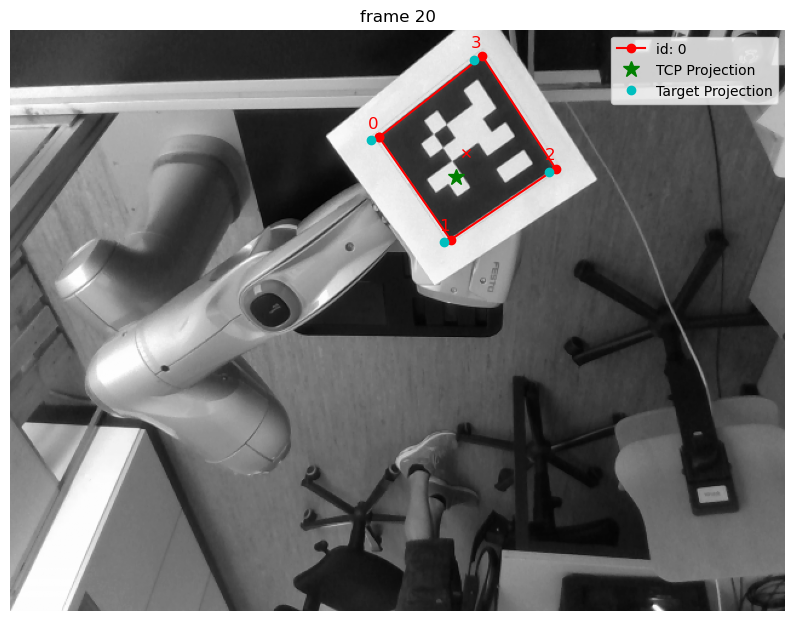

In [11]:
frame_count = 20

frame, gray, detections = load_and_detect(frame_count, data_root, detector)
assert frame_is_valid(frame, detections), f"Frame {frame_count} is invalid"

plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count)

img_points, TCP_world = compute_TCP_image_position(frame, hand_camera_rot, hand_camera_tr)
plt.plot(img_points[0], img_points[1], 'g*', ms=12, label='TCP Projection')

rvec_target_to_gripper, tvec_target_to_gripper = compute_target_to_gripper_transform(hand_camera_rot, hand_camera_tr, data_root, frame_samples, detector, tagsize)
xc_proj = compute_target_image_position(frame, hand_camera_rot, hand_camera_tr, rvec_target_to_gripper, tvec_target_to_gripper, tagsize)
plt.plot(xc_proj[:,0], xc_proj[:,1], 'c.', ms=12, label='Target Projection')
plt.legend()

TCP_world, img_points, xc_proj

In [12]:
calibration_variants = ['TSAI', 'PARK', 'HORAUD', 'ANDREFF', 'DANIILIDIS']

for method in calibration_variants:
    print(f"Running calibration method: {method}")
    rmat, tr, _ = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize, method_str=method)
    rvec_target_to_gripper, tvec_target_to_gripper = compute_target_to_gripper_transform(rmat, tr, data_root, frame_samples, detector, tagsize)

    print(f". Translation to gripper: %s" % tvec_target_to_gripper.flatten())
    print(f". Rotation to gripper   : %s" % rvec_target_to_gripper.flatten())

    mean_error, max_error = compute_reprojection_error_mean_max(rmat, tr, data_root, frame_samples, detector, rvec_target_to_gripper, tvec_target_to_gripper, tagsize)
    print(f'. Distance between projected and detected target center: mean={mean_error:.2f}px, max={max_error:.2f}px')


Running calibration method: TSAI
. Translation to gripper: [-0.07645775  0.0078329   0.04990289]
. Rotation to gripper   : [ 1.76313467 -0.78577728 -1.73759345]
. Distance between projected and detected target center: mean=9.17px, max=20.18px
Running calibration method: PARK
. Translation to gripper: [-0.0733679  -0.00419814  0.0389272 ]
. Rotation to gripper   : [ 1.74596495 -0.78948288 -1.77287564]
. Distance between projected and detected target center: mean=5.19px, max=13.50px
Running calibration method: HORAUD
. Translation to gripper: [-0.07326758 -0.00394353  0.03869417]
. Rotation to gripper   : [ 1.7459534  -0.78837195 -1.77380143]
. Distance between projected and detected target center: mean=5.19px, max=13.65px
Running calibration method: ANDREFF
. Translation to gripper: [ 0.02105973  0.01947881 -0.01038821]
. Rotation to gripper   : [ 1.74639654 -0.7875722  -1.77649882]
. Distance between projected and detected target center: mean=28.22px, max=74.20px
Running calibration me